In [69]:
import numpy as np
import pandas as pd 
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

SEED = 21

# Reading and Merging train Data
### Use only 25 most important features selected previously


In [5]:
FEATURES = ['x_630', 'x_286', 'x_7', 'x_24', 'x_645', 'x_643', 'x_640', 'x_14',
            'x_302', 'x_621', 'x_639', 'x_646', 'x_237', 'x_627', 'x_635', 'x_637',
            'x_620', 'x_644', 'x_619', 'x_15', 'x_5', 'x_618', 'x_625', 'x_628',
            'x_9', 'REPORT_DT', 'TARGET']

In [6]:
df_1 = pd.read_pickle('data/train_part1.pkl')[FEATURES]
df_2 = pd.read_pickle('data/train_part2.pkl')[FEATURES]

In [7]:
df_full = pd.concat((df_1, df_2))

df_full['loan_duration'] = pd.to_numeric(df_full['REPORT_DT'] - df_full['x_9']) / 8.64e+13

df_full = df_full.drop(['x_9', 'REPORT_DT'], axis=1)

In [16]:
df_full = df_full.dropna()

### $X$ $y$ split

In [19]:
X = df_full.drop('TARGET', axis=1)
y = df_full['TARGET']

In [24]:
X = pd.get_dummies(X, columns=['x_618', 'x_625', 'x_628'], drop_first='True')

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    test_size=0.25,
                                                    random_state=SEED)

## Train a baseline LogReg

In [26]:
clf = LogisticRegression(random_state=SEED)
clf.fit(X_train, y_train)

/Users/dmitry.volkov/.pyenv/versions/3.8.6/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=21)

In [32]:
print('TRAIN SCORE :', round(roc_auc_score(y_true  = y_train, 
                                     y_score = clf.predict_proba(X_train)[:,1]),3))

print('TEST SCORE  :', round(roc_auc_score(y_true  = y_test,
                                     y_score = clf.predict_proba(X_test)[:,1]), 3))

TRAIN SCORE : 0.684
TEST SCORE  : 0.685


## Training LightAutoML

In [34]:
import torch
# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

In [36]:
N_THREADS = 4
N_FOLDS = 5
TEST_SIZE = 0.33
TIMEOUT = 1500
TARGET_NAME = 'TARGET'

np.random.seed(SEED)
torch.set_num_threads(N_THREADS)

In [37]:
task = Task('binary')

roles = {
    'target': TARGET_NAME,
}

automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': SEED}
)

In [38]:
automl.fit_predict(df_full, roles = roles)

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Start automl preset with listed constraints:
- time: 1000 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (1220832, 26)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 973.9130010604858 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.8810921774252294
Linear model: C = 5e-05 score = 0.8832137619841656
Linear model: C = 0.0001 score = 0.8835632988191566
Linear model: C = 0.0005 score = 0.884114775847344
Linear model: C = 0.001 score = 0.884114775847344
Linear model: C = 0.005 score = 0.884114775847344

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.8836593587526764
Linear model: C = 5e-05 score = 0.8858379052033905
Linear model: C = 0.0001 score = 0.8861890370712758
Linear model: C = 0.0005 score = 0.8867213766763369
Linear model: C = 0.001 score = 0.88672137667633

Time limit exceeded after calculating fold 1


Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
Time left 842.8553500175476
Start fitting Selector_LightGBM ...

===== Start working with fold 0 for Selector_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.876409
[200]	valid's auc: 0.894708
[300]	valid's auc: 0.902374
[400]	valid's auc: 0.906452
[500]	valid's auc: 0.909253
[600]	valid's auc: 0.91104
[700]	valid's auc: 0.912178
[800]	valid's auc: 0.913017
[900]	valid's auc: 0.913667
[1000]	valid's auc: 0.914169
[1100]	valid's auc: 0.914583
[1200]	valid's auc: 0.914778
[1300]	valid's auc: 0.914812
[1400]	valid's auc: 0.914923
Early stopping, best iteration is:
[1379]	valid's auc: 0.914965
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.908393
[200]	valid's auc: 0.911279
[300

Time limit exceeded after calculating fold 0


Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
Time left -168.77617478370667


Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.


Blending: Optimization starts with equal weights and score 0.8975008873281999
Blending, iter 0: score = 0.8997583062002277, weights = [0.13695437 0.86304563]
Blending, iter 1: score = 0.8997583062002277, weights = [0.13695437 0.86304563]
No score update. Terminated

Automl preset training completed in 1175.48 seconds.


array([[0.00326003],
       [       nan],
       [       nan],
       ...,
       [       nan],
       [0.75454414],
       [0.00137328]], dtype=float32)

##  Check features importance

In [70]:
feature_importance = automl.get_feature_scores()

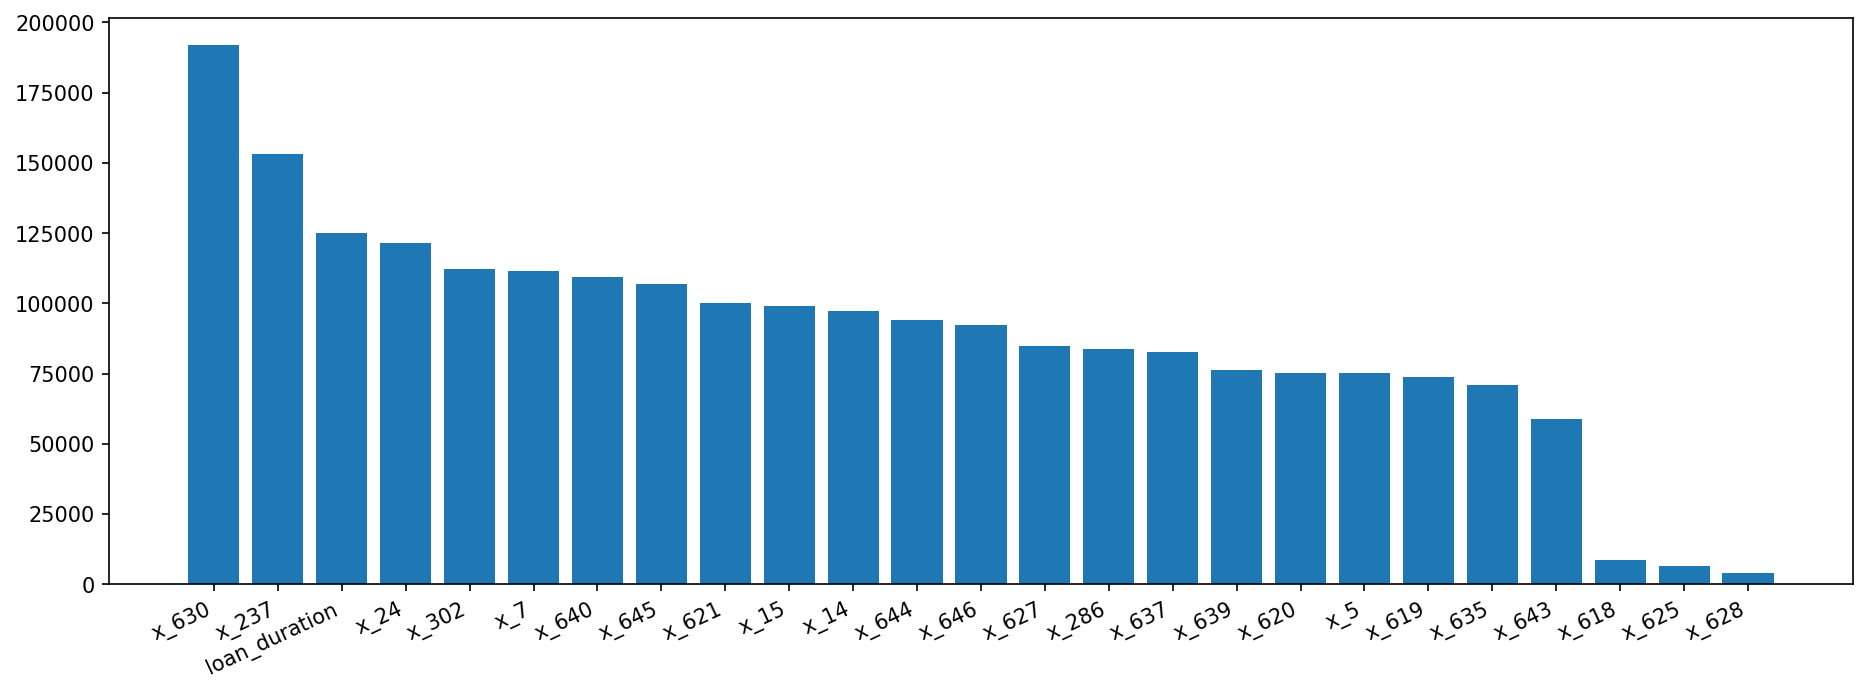

In [71]:
plt.figure(figsize=(15, 5), dpi=150)
plt.bar(x = feature_importance['Feature'][:30],
            height = feature_importance['Importance'][:30])
plt.xticks(rotation=25, ha='right', fontsize=10)
plt.show()

# Make predictions

In [43]:
FEATURES.remove('TARGET')

data_test = pd.read_pickle('data/test_data.pkl')[FEATURES]

data_test['loan_duration'] = pd.to_numeric(data_test['REPORT_DT'] - data_test['x_9']) / 8.64e+13

data_test = data_test.drop(['x_9', 'REPORT_DT'], axis=1)

In [ ]:
y_test_pred = automl.predict(data_test)

# Create Submission File

In [50]:
submission = pd.read_csv('data/submission.csv')

submission['Probability'] = y_test_pred.data[:, 0]

submission.to_csv('submission.csv',index=False)

In [93]:
!kaggle competitions submit -c risk-management-uiim -f submission.csv -m "Hello Sber!"

100%|██████████████████████████████████████| 14.7M/14.7M [00:10<00:00, 1.51MB/s]
Successfully submitted to HACKATON_RISK

# Save Data

In [102]:
df_full.to_pickle('df_full.pkl')

# Save Model

In [103]:
with open('model.pkl', 'wb') as files:
    pickle.dump(automl, files)